# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
#data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

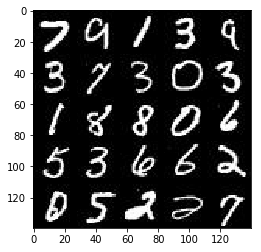

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

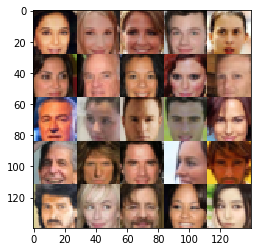

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)
    return (inputs_real, inputs_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha =0.2
    keep_prob = 1
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dp2 = tf.nn.dropout(relu2, keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(dp2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dp3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256

        x4 = tf.layers.conv2d(dp3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        dp4 = tf.nn.dropout(relu4, keep_prob)
        # 2x2x256
        
        # Flatten it
        flat = tf.reshape(dp4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        dp2 = tf.nn.dropout(x2, keep_prob)
        #print(x2.get_shape())
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(dp2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        dp3 = tf.nn.dropout(x3, keep_prob)
        #print(x3.get_shape())
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(dp3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return (d_train_opt, g_train_opt)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width =  data_shape[1]
    image_height = data_shape[2]
    if data_image_mode == 'RGB':
        image_channel = 3
    else:
        image_channel = 1
    input_real, input_z, lr =  model_inputs(image_width, image_height, image_channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images = batch_images.reshape(batch_size, image_width, image_height, image_channel)
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,25,input_z,image_channel, data_image_mode)
     #   saver.save(sess, './checkpoints/generator.ckpt')

   # with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.6105
Epoch 1/2... Discriminator Loss: 0.2578... Generator Loss: 14.5129
Epoch 1/2... Discriminator Loss: 0.4316... Generator Loss: 12.7736
Epoch 1/2... Discriminator Loss: 0.0990... Generator Loss: 3.8210
Epoch 1/2... Discriminator Loss: 0.0307... Generator Loss: 8.2305
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 1.3771
Epoch 1/2... Discriminator Loss: 0.2255... Generator Loss: 2.2952
Epoch 1/2... Discriminator Loss: 1.7867... Generator Loss: 0.3017
Epoch 1/2... Discriminator Loss: 0.2552... Generator Loss: 3.8692
Epoch 1/2... Discriminator Loss: 0.0435... Generator Loss: 5.0409


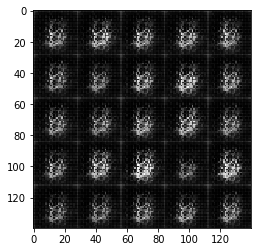

Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 7.4246
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 7.7500
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 10.2545
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 0.1855... Generator Loss: 3.5768
Epoch 1/2... Discriminator Loss: 0.2222... Generator Loss: 2.3012
Epoch 1/2... Discriminator Loss: 0.0757... Generator Loss: 5.4482
Epoch 1/2... Discriminator Loss: 0.5784... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 0.1690... Generator Loss: 3.3047
Epoch 1/2... Discriminator Loss: 0.0809... Generator Loss: 4.5806


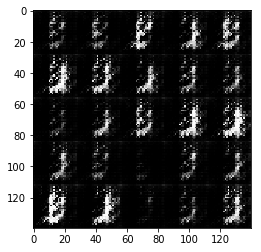

Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 1.2875
Epoch 1/2... Discriminator Loss: 0.0899... Generator Loss: 6.7520
Epoch 1/2... Discriminator Loss: 2.5694... Generator Loss: 0.2535
Epoch 1/2... Discriminator Loss: 0.1587... Generator Loss: 3.9804
Epoch 1/2... Discriminator Loss: 0.3334... Generator Loss: 1.8964
Epoch 1/2... Discriminator Loss: 0.0921... Generator Loss: 5.3116
Epoch 1/2... Discriminator Loss: 0.2008... Generator Loss: 2.5181
Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 3.3004
Epoch 1/2... Discriminator Loss: 0.2552... Generator Loss: 3.2982
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 1.5495


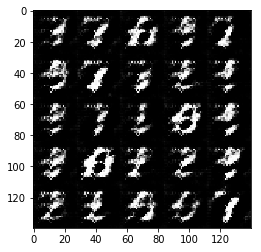

Epoch 1/2... Discriminator Loss: 0.2425... Generator Loss: 3.5802
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 6.6586
Epoch 1/2... Discriminator Loss: 0.1893... Generator Loss: 4.1225
Epoch 1/2... Discriminator Loss: 0.1437... Generator Loss: 3.4282
Epoch 1/2... Discriminator Loss: 0.2025... Generator Loss: 4.0733
Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 1.4432
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 6.3581
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 1.2683
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 1.2709


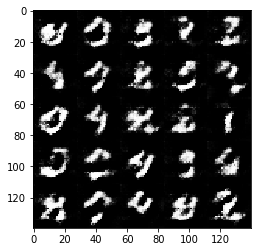

Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 6.8309
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 0.3494... Generator Loss: 2.0332
Epoch 1/2... Discriminator Loss: 0.3582... Generator Loss: 2.4566
Epoch 1/2... Discriminator Loss: 0.2773... Generator Loss: 2.8452
Epoch 1/2... Discriminator Loss: 0.4206... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 0.3296... Generator Loss: 2.3872
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 1.8533
Epoch 1/2... Discriminator Loss: 0.2083... Generator Loss: 3.2893
Epoch 1/2... Discriminator Loss: 0.2871... Generator Loss: 2.3440


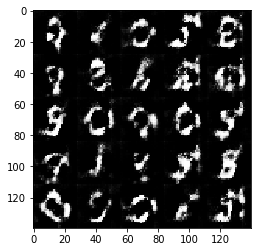

Epoch 1/2... Discriminator Loss: 0.3076... Generator Loss: 3.6762
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 0.4204... Generator Loss: 1.6990
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.2213
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 2.2877
Epoch 1/2... Discriminator Loss: 0.4620... Generator Loss: 3.6340
Epoch 1/2... Discriminator Loss: 0.5934... Generator Loss: 5.2026
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.3350
Epoch 1/2... Discriminator Loss: 0.6574... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 0.3541... Generator Loss: 2.1224


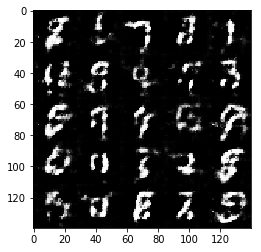

Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.6334
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 1.3395
Epoch 1/2... Discriminator Loss: 0.3132... Generator Loss: 2.1778
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.0367
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 0.7426... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 0.4668... Generator Loss: 1.4258
Epoch 1/2... Discriminator Loss: 0.4304... Generator Loss: 2.0020
Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 1.6046
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.0782


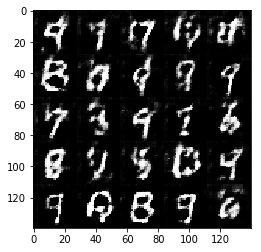

Epoch 1/2... Discriminator Loss: 0.3386... Generator Loss: 3.3613
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 0.4103... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 0.4587... Generator Loss: 2.5650
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 2.5965
Epoch 1/2... Discriminator Loss: 0.8186... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 1.3685
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 2.3429
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 2.3666


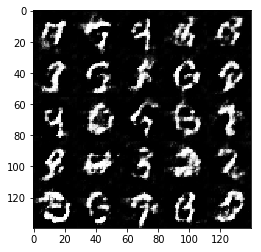

Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 0.5415... Generator Loss: 2.2356
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 3.0012
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 1.9166
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 1.6940
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.3119


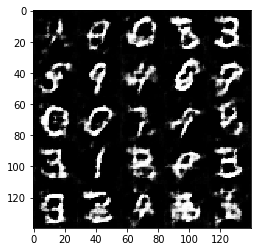

Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 1.2199
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 1.5245
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 0.4880
Epoch 1/2... Discriminator Loss: 0.3508... Generator Loss: 3.1971
Epoch 1/2... Discriminator Loss: 0.5134... Generator Loss: 1.5391
Epoch 1/2... Discriminator Loss: 0.7066... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 0.4812... Generator Loss: 1.7057
Epoch 1/2... Discriminator Loss: 0.5997... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 0.4965... Generator Loss: 1.6139
Epoch 1/2... Discriminator Loss: 0.6827... Generator Loss: 0.9925


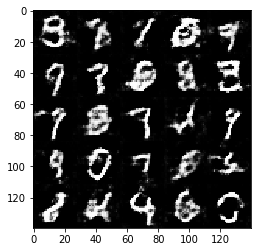

Epoch 1/2... Discriminator Loss: 0.4599... Generator Loss: 1.8343
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 0.4554... Generator Loss: 2.2362
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.7358
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 2.0256
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 0.7319... Generator Loss: 1.5046
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 1.8021
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.3889


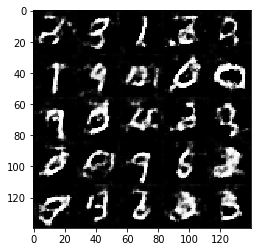

Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 1.4885
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 1.4194
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 0.4732
Epoch 1/2... Discriminator Loss: 0.2277... Generator Loss: 3.0065
Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 1.7532
Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 0.5803


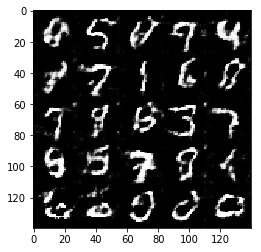

Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 0.3487... Generator Loss: 1.8592
Epoch 1/2... Discriminator Loss: 0.6499... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 1.1019
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 0.2395... Generator Loss: 1.9934
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 1.2859
Epoch 1/2... Discriminator Loss: 0.3408... Generator Loss: 1.9353


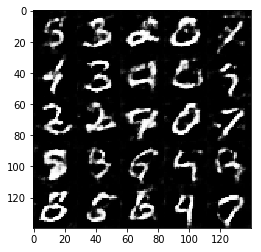

Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 0.3240... Generator Loss: 2.2423
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.6897... Generator Loss: 0.2971
Epoch 1/2... Discriminator Loss: 0.5319... Generator Loss: 2.8341
Epoch 1/2... Discriminator Loss: 0.3808... Generator Loss: 1.9017
Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 1.4342
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.0838


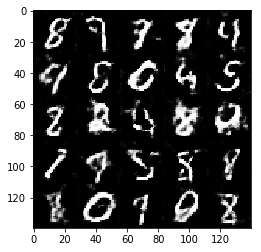

Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 1.0583
Epoch 1/2... Discriminator Loss: 0.3489... Generator Loss: 1.8051
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 1.1214
Epoch 1/2... Discriminator Loss: 0.5688... Generator Loss: 2.1030
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 0.5655... Generator Loss: 1.2596
Epoch 1/2... Discriminator Loss: 0.2800... Generator Loss: 2.0411
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 0.5046... Generator Loss: 1.9009
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.0087


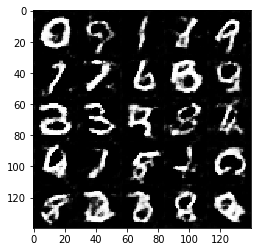

Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 0.4078... Generator Loss: 1.8614
Epoch 1/2... Discriminator Loss: 0.9100... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 1.6773
Epoch 1/2... Discriminator Loss: 0.2873... Generator Loss: 1.9364
Epoch 1/2... Discriminator Loss: 0.5147... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 0.5460... Generator Loss: 1.4467
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.5944


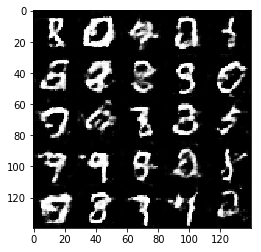

Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 2.5894
Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 2.2622
Epoch 1/2... Discriminator Loss: 1.6136... Generator Loss: 4.7769
Epoch 1/2... Discriminator Loss: 0.5212... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 1.5791
Epoch 1/2... Discriminator Loss: 0.2493... Generator Loss: 1.9584
Epoch 1/2... Discriminator Loss: 0.6081... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 1.1883
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 1.4492


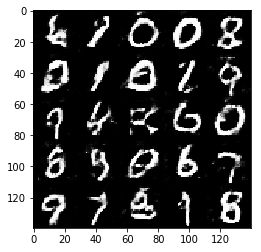

Epoch 1/2... Discriminator Loss: 0.6447... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 0.8142... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.9048... Generator Loss: 0.2206
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 1.1781
Epoch 1/2... Discriminator Loss: 0.2725... Generator Loss: 1.9070
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 1.4838
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 0.2695... Generator Loss: 2.0252
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.4375


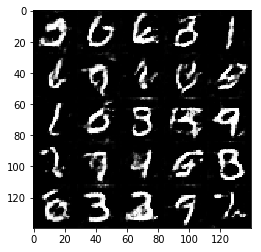

Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 2.5084... Generator Loss: 0.1408
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 0.4185... Generator Loss: 2.1562
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 0.8115
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 0.8420


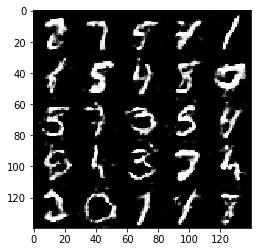

Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 0.5976... Generator Loss: 3.6856
Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 2.3361
Epoch 2/2... Discriminator Loss: 0.1800... Generator Loss: 2.6681
Epoch 2/2... Discriminator Loss: 0.4055... Generator Loss: 1.6287
Epoch 2/2... Discriminator Loss: 0.3149... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 1.4013
Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 1.2551


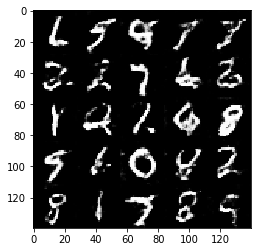

Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 1.4763
Epoch 2/2... Discriminator Loss: 0.3358... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 0.2792... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 0.6204... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 0.6850


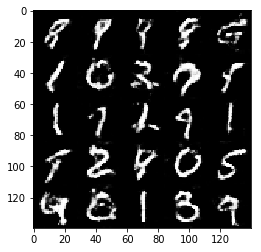

Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 0.5817... Generator Loss: 1.0386
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.0165
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 0.6389... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.7874... Generator Loss: 0.2999
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.4436


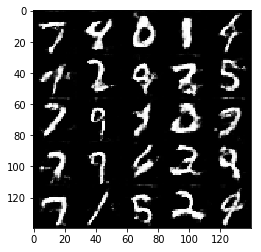

Epoch 2/2... Discriminator Loss: 1.6062... Generator Loss: 0.3439
Epoch 2/2... Discriminator Loss: 0.5065... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.4369
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.5163
Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 2.3345


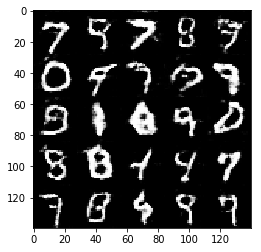

Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.4631
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 0.2969... Generator Loss: 1.9919
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.4099
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.5540
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 0.3525... Generator Loss: 1.8231


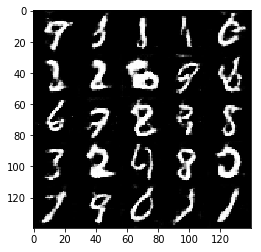

Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 1.1236
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 0.8349
Epoch 2/2... Discriminator Loss: 0.5302... Generator Loss: 2.0540
Epoch 2/2... Discriminator Loss: 0.3949... Generator Loss: 1.6396
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 0.2900... Generator Loss: 1.9496
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.5415


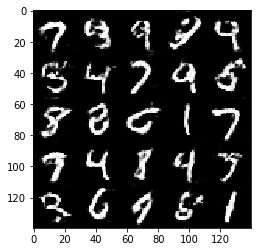

Epoch 2/2... Discriminator Loss: 2.8291... Generator Loss: 0.0853
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 1.1145
Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.4001
Epoch 2/2... Discriminator Loss: 0.4288... Generator Loss: 1.3199
Epoch 2/2... Discriminator Loss: 0.2415... Generator Loss: 2.3375
Epoch 2/2... Discriminator Loss: 0.5637... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 0.7528


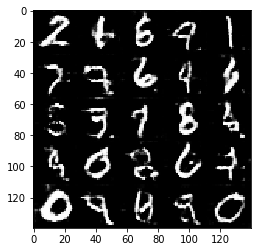

Epoch 2/2... Discriminator Loss: 0.4397... Generator Loss: 1.4216
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.5483
Epoch 2/2... Discriminator Loss: 1.8862... Generator Loss: 0.2144
Epoch 2/2... Discriminator Loss: 0.2351... Generator Loss: 3.6655
Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 0.5681... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 0.4736... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 0.2570... Generator Loss: 2.0639
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 4.4861


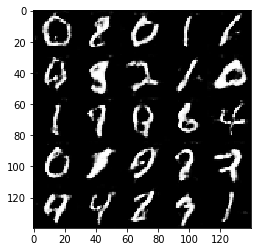

Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 0.4556... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 0.6090... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 0.3201... Generator Loss: 2.2832
Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.0027
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 0.2429... Generator Loss: 1.9450
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 0.8407


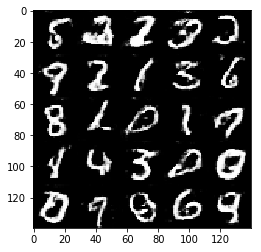

Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 3.2905
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 1.5718
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.4480
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.8234... Generator Loss: 0.2758
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 0.3269... Generator Loss: 1.6872
Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.3986
Epoch 2/2... Discriminator Loss: 0.3042... Generator Loss: 1.7713


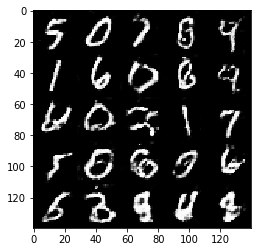

Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.4818
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 1.3202
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 1.1178
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 0.8327... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 2.5964... Generator Loss: 0.1389
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 0.8981


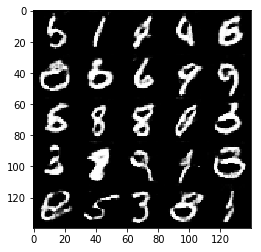

Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.4058
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.4618
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.8479... Generator Loss: 0.2175
Epoch 2/2... Discriminator Loss: 1.6023... Generator Loss: 0.4645
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.4774
Epoch 2/2... Discriminator Loss: 0.5427... Generator Loss: 1.4180
Epoch 2/2... Discriminator Loss: 1.6458... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 0.3391... Generator Loss: 2.3997


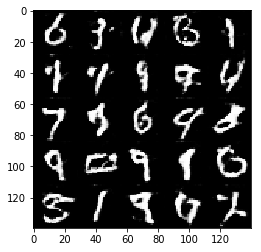

Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.4328
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 1.2334
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.5367... Generator Loss: 0.3569
Epoch 2/2... Discriminator Loss: 0.1884... Generator Loss: 2.3919
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.4616
Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 3.5614
Epoch 2/2... Discriminator Loss: 0.3580... Generator Loss: 1.4755
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 0.8680


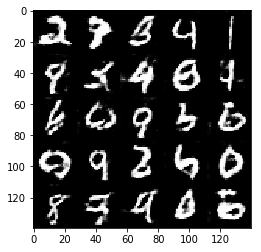

Epoch 2/2... Discriminator Loss: 2.0596... Generator Loss: 0.1931
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.3670
Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 1.5453
Epoch 2/2... Discriminator Loss: 0.6214... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 1.6046... Generator Loss: 0.3026
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 1.2989


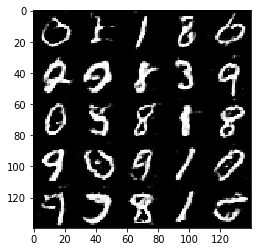

Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 0.4010... Generator Loss: 1.7296
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.2472
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 0.5885... Generator Loss: 0.9691
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 0.5377... Generator Loss: 1.3272
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 4.6119
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.0821


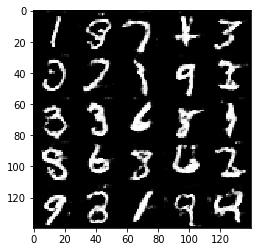

Epoch 2/2... Discriminator Loss: 0.4805... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 0.2962... Generator Loss: 2.6747
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.4283
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 0.9294
Epoch 2/2... Discriminator Loss: 0.5559... Generator Loss: 1.2285
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 0.2190... Generator Loss: 2.6011
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 3.8846


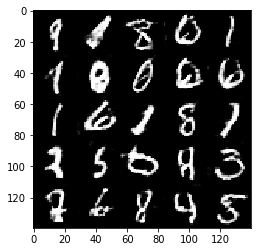

Epoch 2/2... Discriminator Loss: 1.6002... Generator Loss: 0.3823
Epoch 2/2... Discriminator Loss: 0.3654... Generator Loss: 1.6665
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 1.5347
Epoch 2/2... Discriminator Loss: 0.4287... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 2.2447... Generator Loss: 0.1925
Epoch 2/2... Discriminator Loss: 0.1879... Generator Loss: 2.6743
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.4082
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 1.4974
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 1.5454


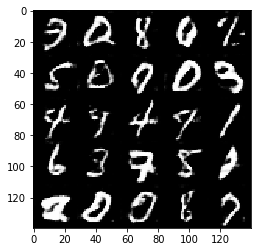

Epoch 2/2... Discriminator Loss: 0.4036... Generator Loss: 1.6328
Epoch 2/2... Discriminator Loss: 0.6741... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 2.2784... Generator Loss: 8.1328
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 2.2036... Generator Loss: 0.2275
Epoch 2/2... Discriminator Loss: 1.4599... Generator Loss: 0.4188
Epoch 2/2... Discriminator Loss: 2.9817... Generator Loss: 0.0798
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 1.4832
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 0.1580... Generator Loss: 2.5927


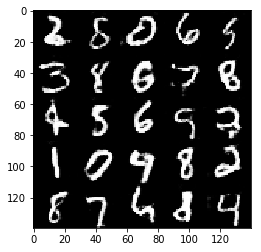

Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.9084... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 0.1984... Generator Loss: 3.5694


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 12.2860
Epoch 1/1... Discriminator Loss: 0.0748... Generator Loss: 12.4060
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 9.9325
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 10.1619
Epoch 1/1... Discriminator Loss: 2.1650... Generator Loss: 0.1376
Epoch 1/1... Discriminator Loss: 0.2994... Generator Loss: 4.0994
Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 6.1944
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 2.1608... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 1.3460


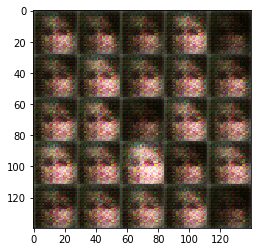

Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 2.9140
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 2.5792
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.3088
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 2.2897
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 1.6569
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.5440


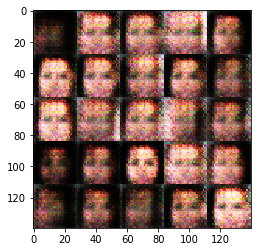

Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 2.2359
Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 2.4456
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 2.7721
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 3.5709
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.6224
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 4.0241
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.8673


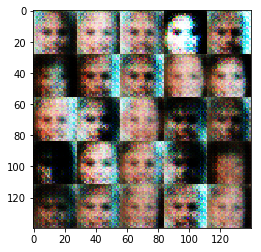

Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 3.2255
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.3429
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 3.0881
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 2.6405
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.1446


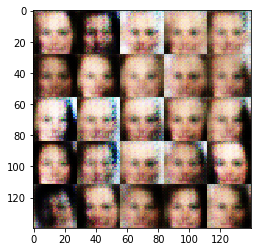

Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 2.5061
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 3.0237
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.6402
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.3638


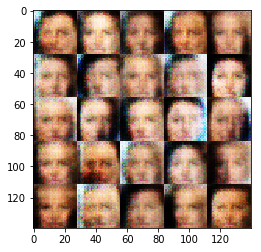

Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.6016
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.4466


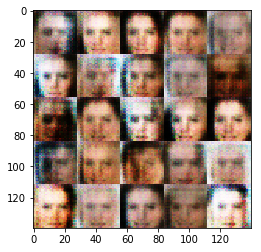

Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 1.7922
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 2.0006
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.1454


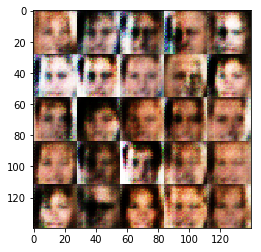

Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.4445
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.0752


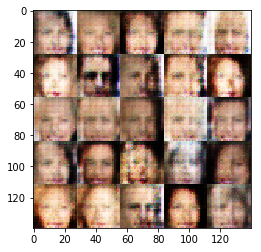

Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 3.0184
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.9666
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.7452


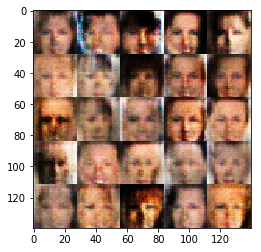

Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 2.2113
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 2.0811
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.2125


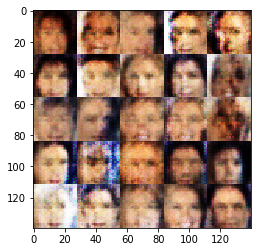

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 2.1900
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.4057
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.6361
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 3.5922
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.6156
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.5432


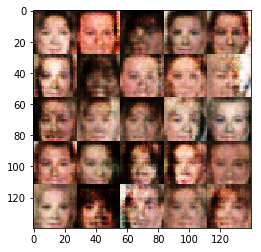

Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.8728
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 2.8091
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.3958


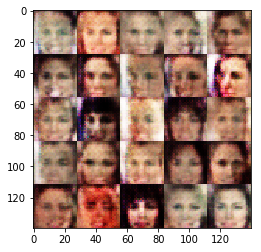

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 0.9124


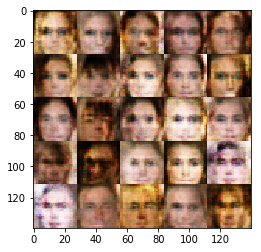

Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 2.0592
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 2.5422
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.7711


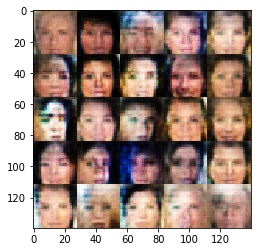

Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 2.5839
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 2.7151
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.1819


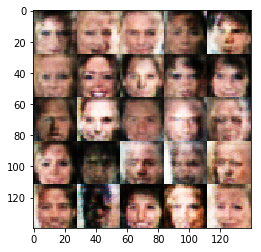

Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.6246
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.0757


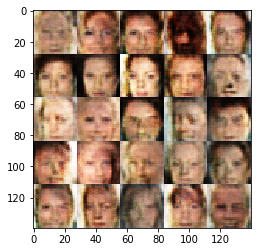

Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 2.1572
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.6593


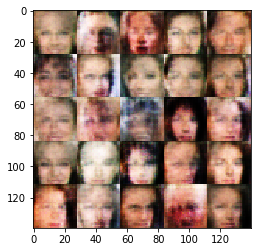

Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 2.3156
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.8033
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.4434


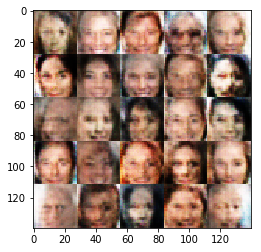

Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.1562


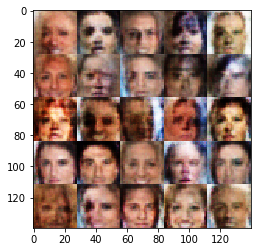

Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 2.2327
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.8408
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 1.9907
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 0.7310


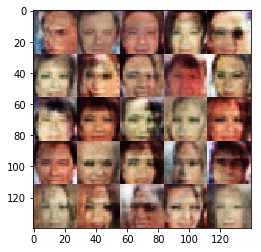

Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.6757... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.7728
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.2126


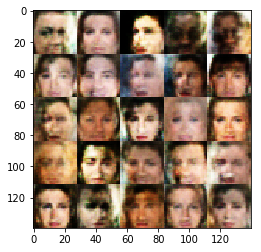

Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 2.0882
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.2873
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.4711


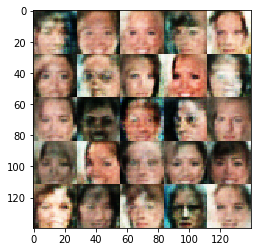

Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.3356... Generator Loss: 1.8710
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.3357
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.7328


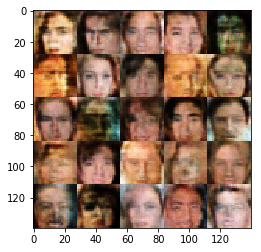

Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 1.8445
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.4807


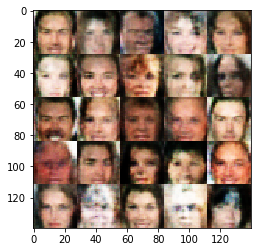

Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.2926
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 1.6840
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 0.7811


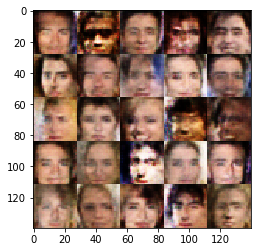

Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.1629
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 1.8768
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 1.5397


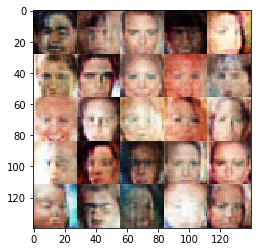

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 1.5064
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 2.3977


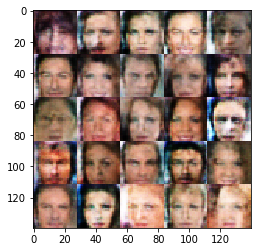

Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.7593
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.6681
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 3.1146
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.7196
Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 2.0257
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 1.3657


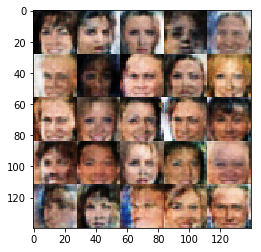

Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 3.1258
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 2.0399
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.0984
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.8444... Generator Loss: 0.2119
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 0.9882


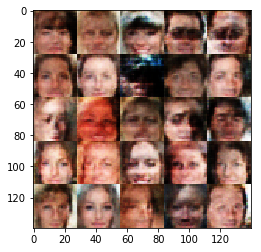

Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 3.3106
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.6159


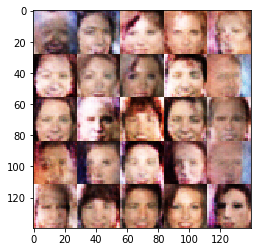

Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.9299... Generator Loss: 0.2285
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.9563
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.4740


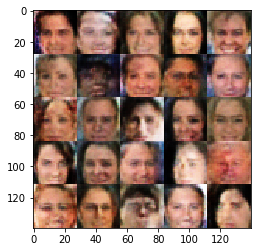

Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 2.0445
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.3979


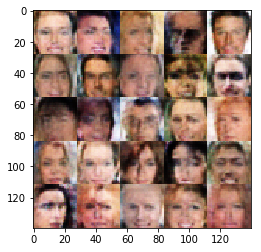

Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.7085... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.3096


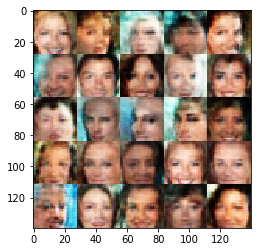

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 2.0721
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 0.8112


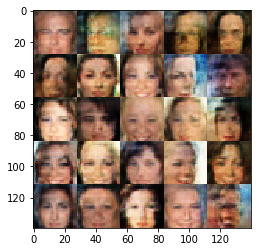

Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 1.8624
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 1.7690
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.2420... Generator Loss: 2.1902
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 1.8638


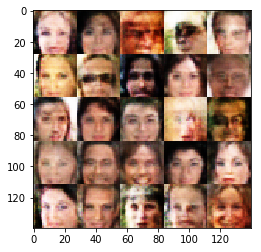

Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.3157
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.5687


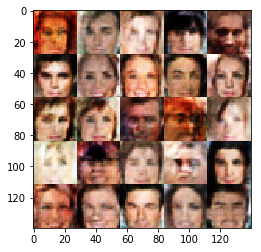

Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 2.0451
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.3066


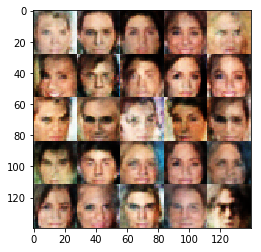

Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.2550


KeyboardInterrupt: 

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.